# EAGE 2020 abstract, Figure 1

## Transient CSEM for a homogeneous fullspace

The example is based on the first example (Figures 3-4) of Mulder et al., 2008, Geophysics: "Time-domain modeling of electromagnetic diffusion with a frequency-domain code". These results are shown at the end of the notebook.

The published example took roughly **3.75 hours**, whereas here we need less than **2 minutes**.

#### References

> Mulder, W. A., M. Wirianto, and E. Slob, 2008, Time-domain modeling of electromagnetic diffusion with a frequency-domain code: Geophysics, 73, F1-F8; DOI: [10.1190/1.2799093](https://doi.org/10.1190/1.2799093).

In [1]:
import emg3d
import empymod
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Style adjustments
%matplotlib notebook

## Model and Survey

### Model
- Homogeneous fullspace of 1 Ohm.m.

### Survey
- Source at origin.
- Receiver at an inline-offset of 900 m.
- Both source and receiver are x-directed electric dipoles.

In [3]:
src = [0, 0, 0, 0, 0]
rec = [900, 0, 0, 0, 0]
res = 1
depth = []

## Fourier Transforms parameters

We only calculate frequencies $0.05 < f < 21$ Hz, which yields enough precision for our purpose.

This means, instead of 30 frequencies from 0.0002 - 126.4 Hz, we only need 14 frequencies from 0.05 - 20.0 Hz.

In [4]:
# Define desired times.
time = np.logspace(-2, 1, 201)

# Initiate a Fourier instance
Fourier = emg3d.utils.Fourier(
    time=time,
    fmin=0.05,
    fmax=21,
    ft='fftlog',  # Fourier transform to use
    ftarg={'pts_per_dec': 5, 'add_dec': [-2, 1], 'q': 0},
)

# Dense frequencies for comparison reasons
freq_dense = np.logspace(np.log10(Fourier.freq_req.min()), np.log10(Fourier.freq_req.max()), 301)

   time        [s] :  0.01 - 10 : 201  [min-max; #]
   Fourier         :  FFTLog
     > pts_per_dec :  5
     > add_dec     :  [-2.  1.]
     > q           :  0.0
   Req. freq  [Hz] :  0.000200364 - 126.421 : 30  [min-max; #]
   Calc. freq [Hz] :  0.0503292 - 20.0364 : 14  [min-max; #]


## Frequency-domain calculation

In [5]:
# To store the info of each frequency.
values = {}

# Initiate data with zeros.
data = np.zeros(Fourier.freq_calc.size, dtype=complex)

# Input for adaptive grid creation.
gridinput = {
    'res': res,               # Fullspace resistivity.
    'min_width': [20., 40.],  # Restrict the cell width within the survey domain.
    'return_info': True,      # To get back some information for later.
    'pps': 12,                # Many points, to have a small min cell width.
    'alpha': [1, 1.3, 0.01],  # Lower the alpha will improve the result, but slow down calculation.
    'verb': 0,                # Set to 1 to see more info per frequency.
}

# Start the timer.
runtime = emg3d.utils.Time()

# Loop over frequencies, going from high to low.
for fi, frq in enumerate(Fourier.freq_calc[::-1]):
    print(f"  {fi+1:2}/{Fourier.freq_calc.size} :: {frq:10.6f} Hz", end='\r')
            
    # Initiate log for this frequency.
    thislog = {}
    thislog['freq'] = frq

    # Get cell widths and origin in x and y/z.
    xx, x0, hix = emg3d.utils.get_hx_h0(
        freq=frq, fixed=src[0], domain=[-200, 1100], **gridinput)
    yz, yz0, hiyz = emg3d.utils.get_hx_h0(
        freq=frq, fixed=src[1], domain=[-50, 50], **gridinput)

    # Store values in log.
    thislog['alpha'] = [np.min([hix['amin'], hiyz['amin']]),
                        np.max([hix['amax'], hiyz['amax']])]
    thislog['dminmax'] = [np.min([hix['dmin'], hiyz['dmin']]),
                          np.max([hix['dmax'], hiyz['dmax']])]

    # Initiate mesh.
    grid = discretize.TensorMesh([xx, yz, yz], x0=np.array([x0, yz0, yz0]))
    thislog['nC'] = grid.nC  # Store number of cells in log.

    # Interpolate the starting electric field from the last one (can speed-up the calculation).
    if fi == 0:
        efield = emg3d.utils.Field(grid, freq=frq)
    else:
        efield = emg3d.utils.grid2grid(old_grid, efield, grid, method='cubic', extrapolate=False)
        efield = emg3d.utils.Field(grid, efield, freq=frq)

    # Generate model
    model = emg3d.utils.Model(grid, res_x=res)
        
    # Define source.
    sfield = emg3d.utils.get_source_field(grid, src, frq, strength=0)

    # Solve the system.
    info = emg3d.solve(
        grid, model, sfield, efield=efield, verb=-1, return_info=True,
        sslsolver=True, semicoarsening=True, linerelaxation=True,
    )
    
    data[-fi-1] = emg3d.utils.get_receiver(grid, efield.fx, (rec[:3]))

    # Store info
    thislog['info'] = info
    
    # Stare thislog in values.
    values[int(frq*1e6)] = thislog

    # Store the grid for the interpolation.
    old_grid = grid
    
# Stop the timer.
total_time = runtime.runtime

:: emg3d :: 4.9e-07; 1(5); 0:00:03; CONVERGED
:: emg3d :: 4.1e-07; 1(4); 0:00:05; CONVERGED
:: emg3d :: 4.8e-07; 1(5); 0:00:06; CONVERGED
:: emg3d :: 4.3e-07; 1(6); 0:00:08; CONVERGED
:: emg3d :: 5.3e-07; 1(6); 0:00:06; CONVERGED
:: emg3d :: 3.7e-07; 1(6); 0:00:06; CONVERGED
:: emg3d :: 3.7e-07; 1(6); 0:00:05; CONVERGED
:: emg3d :: 6.2e-07; 1(6); 0:00:06; CONVERGED
:: emg3d :: 5.4e-08; 1(7); 0:00:08; CONVERGED
:: emg3d :: 1.1e-07; 1(7); 0:00:06; CONVERGED
:: emg3d :: 1.2e-07; 1(7); 0:00:10; CONVERGED
:: emg3d :: 3.0e-07; 1(7); 0:00:10; CONVERGED
:: emg3d :: 4.8e-07; 1(7); 0:00:12; CONVERGED
:: emg3d :: 8.2e-07; 1(7); 0:00:12; CONVERGED


In [6]:
print(f"\n{16*' '}**** TOTAL RUNTIME :: {total_time} ****\n")
for key, value in values.items():
    print(f"  {value['freq']:7.3f} Hz: {value['info']['it_mg']:2g}/{value['info']['it_ssl']:g} it; "
          f"{value['info']['time']:4.0f} s; a: {value['alpha'][0]:.3f} / {value['alpha'][1]:.3f} ; "
          f"nC: {value['nC']:8,.0f}; a: {value['dminmax'][0]:5.0f} / {value['dminmax'][1]:7.0f}")


                **** TOTAL RUNTIME :: 0:01:49 ****

   20.036 Hz:  5/1 it;    3 s; a: 1.000 / 1.260 ; nC:   46,080; a:    20 /     160
   12.642 Hz:  4/1 it;    5 s; a: 1.000 / 1.170 ; nC:   98,304; a:    20 /     154
    7.977 Hz:  5/1 it;    6 s; a: 1.000 / 1.200 ; nC:   98,304; a:    20 /     214
    5.033 Hz:  6/1 it;    8 s; a: 1.000 / 1.230 ; nC:   98,304; a:    20 /     295
    3.176 Hz:  6/1 it;    6 s; a: 1.000 / 1.250 ; nC:   81,920; a:    24 /     428
    2.004 Hz:  6/1 it;    6 s; a: 1.000 / 1.210 ; nC:   81,920; a:    30 /     427
    1.264 Hz:  6/1 it;    5 s; a: 1.000 / 1.210 ; nC:   65,536; a:    37 /     538
    0.798 Hz:  6/1 it;    6 s; a: 1.000 / 1.230 ; nC:   65,536; a:    40 /     726
    0.503 Hz:  7/1 it;    8 s; a: 1.000 / 1.260 ; nC:   65,536; a:    40 /    1017
    0.318 Hz:  7/1 it;    6 s; a: 1.000 / 1.280 ; nC:   65,536; a:    40 /    1421
    0.200 Hz:  7/1 it;   10 s; a: 1.000 / 1.270 ; nC:  102,400; a:    40 /    1832
    0.126 Hz:  7/1 it;   10 s; a: 

### Store data

In [7]:
# emg3d.utils.data_write('fullspace', 'data', data)
data = emg3d.utils.data_read('fullspace', 'data')

## Frequency domain

### Calculate analytical result and interpolate missing responses

In [8]:
data_int = Fourier.interpolate(data)

# Calculate analytical result using empymod (epm)
epm_req = empymod.bipole(src, rec, depth, res, Fourier.freq_req, verb=1)
epm_dense = empymod.bipole(src, rec, depth, res, freq_dense, verb=1)

# Calculate error
err =  np.clip(100*abs((data_int.imag-epm_req.imag)/epm_req.imag), 0.1, 10)

## Time domain

### Do the transform and calculate analytical and precise result.

In [9]:
# Calculate corresponding time-domain signal.
data_time = Fourier.freq2time(data, rec[0])

# Analytical result
epm_time_precise = empymod.bipole(src, rec, depth, res, time, signal=0, verb=1)

# Relative error and peak error
err_egd = np.clip(100*abs((data_time-epm_time_precise)/epm_time_precise), 0.1, 10)

### Plot it

<IPython.core.display.Javascript object>


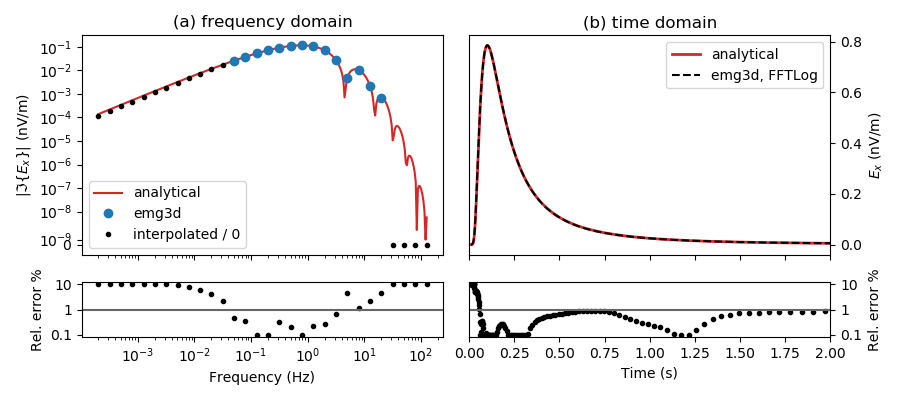

In [10]:
plt.figure(figsize=(9, 4))

# Imaginary, log-symlog
ax1 = plt.subplot2grid((4, 2), (0, 0), rowspan=3)
plt.title('(a) frequency domain')
plt.plot(freq_dense, 1e9*abs(epm_dense.imag), 'C3', label='analytical')
plt.plot(Fourier.freq_calc, 1e9*abs(data.imag), 'C0o', label='emg3d')
plt.plot(Fourier.freq_req[~Fourier.freq_calc_i],
         1e9*abs(data_int[~Fourier.freq_calc_i].imag), 'k.', label='interpolated / 0')
plt.ylabel('$|\Im\{E_x\}|$ (nV/m)')
plt.xscale('log')
plt.yscale('symlog', linthreshy=5e-9)
ax1.set_xticklabels([])
plt.legend()

# Imaginary, error
ax2 = plt.subplot2grid((4, 2), (3, 0))
plt.plot(Fourier.freq_req, err, 'k.')
plt.axhline(1, color='.4')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Rel. error %')
plt.ylim([8e-2, 12])
plt.yticks([0.1, 1, 10], ('0.1', '1', '10'))


# Imaginary, log-symlog
ax3 = plt.subplot2grid((4, 2), (0, 1), rowspan=3)
plt.title('(b) time domain')
plt.plot(time, epm_time_precise*1e9, 'C3', lw=2, label='analytical')
plt.plot(time, data_time*1e9, 'k--', label='emg3d, FFTLog')
plt.xlim([0, 2])
plt.ylabel('$E_x$ (nV/m)')
ax3.set_xticklabels([])
plt.legend()
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")

# Imaginary, error
ax4 = plt.subplot2grid((4, 2), (3, 1))
plt.plot(time, err_egd, 'k.')
plt.axhline(1, color='.4')

plt.yscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Rel. error %')
plt.xlim([0, 2])
plt.ylim([8e-2, 12])
plt.yticks([0.1, 1, 10], ('0.1', '1', '10'))
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
        
plt.tight_layout()

# plt.savefig('../figures/fullspace.pdf')
plt.show()

In [11]:
emg3d.Report([empymod, ])

--------------------------------------------------------------------------------
  Date: Mon Jan 06 14:31:07 2020 CET

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           15.5 GB : RAM
           Jupyter : Environment

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

            1.10.2 : empymod
            1.17.4 : numpy
             1.3.2 : scipy
            0.46.0 : numba
0.9.3.dev1+gc9e595e : emg3d
            7.10.2 : IPython
             3.1.1 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------